In [1]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits import mplot3d
from IPython.display import clear_output
#%matplotlib widget
%matplotlib inline

# Deep Galerkin Tests

## ODE: $f'(x) = xf(x),\, f(0)=1$

In [ ]:
# ODE_Net architecture:
# 2 hidden layers of width 128
# and tanh activation functions

class ODE_Net(nn.Module):
    def __init__(self):
        super(ODE_Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1))
        
    def forward(self, x):
        return self.net(x)

In [ ]:
f = ODE_Net()
num_eps = 8000
low = -2.0
high = 2.0
sampler = torch.distributions.uniform.Uniform(low, high)
inish = torch.tensor([1.0])
lr = 0.001
losses = []

# initialize values for ADAM optimizer
m = []
v = []
for param in f.parameters():
    m.append(torch.zeros_like(param))
    v.append(torch.zeros_like(param))
β1 = torch.tensor([0.9])
β2 = torch.tensor([0.999])
ϵ = 1e-8

# mini-batches successfully implemented
mini_batch_size = 128

for ep in range(num_eps):
    if ep == 2000:
        lr = 0.0005
    if ep == 3000:
        lr = 0.0001
    
    f.zero_grad()
    
    # sample a mini-batch of x values from a given distribution
    x = sampler.sample((mini_batch_size, 1))
    x.requires_grad_()
    
    # evaluate forward pass, compute derivative of network with respect to x,
    # and evaluate network at intial time
    f_output = f(x)
    # ---------------------------------
    f_prime = torch.autograd.grad(torch.sum(f_output), x, create_graph=True)[0]
    # alternatively, you can use torch.autograd.grad(f_output, x, create_graph=True, grad_outputs=torch.ones_like(f_output))[0]
    # ---------------------------------
    f_inish = f(torch.tensor([0.0]))
    
    # compute loss for ODE and initial condition
    L1 = torch.mean(torch.pow(f_prime - x*f_output, 2))
    L2 = torch.pow(f_inish - inish, 2)
    G = L1 + L2
    losses.append(torch.log(G).detach())
    
    # compute derivative of loss with respect to network parameters
    G_grad = torch.autograd.grad(G, f.parameters(), retain_graph=True)
    
    # update network parameters with ADAM
    with torch.no_grad():
        i = 0
        for param in f.parameters():
            m[i] = β1*m[i] + (1-β1)*G_grad[i]
            v[i] = β2*v[i] + (1-β2)*torch.pow(G_grad[i], 2)
            m_hat = m[i]/(1-β1**(ep+1))
            v_hat = v[i]/(1-β2**(ep+1))
            param -= lr*m_hat/(torch.sqrt(v_hat)+ϵ)
            i += 1
            
    # plot log-loss
    if ep % 100 == 0:
        clear_output(wait=True)
        plt.plot(losses)
        plt.show()

In [ ]:
# plot optimized nural net and actual solution
x_vals = torch.reshape(torch.linspace(-2, 2, 100), (-1, 1))
true_solution = torch.exp(x_vals*x_vals/2)
#print(x_vals.size(), true_solution.size())
with torch.no_grad():
    f_vals = f(x_vals)
    print(f_vals.size())
plt.plot(x_vals, f_vals, x_vals, true_solution)
plt.grid()

## PDE Test: $u_t(x,t) + u_x(x,t) = 0, \, u(x,0) = \sin(x)$

In [2]:
def funcLearnRate(numIter):    
    if numIter <= 5000:
        return 1E-4;
    elif numIter <= 10000:
        return 5E-5
    elif numIter <= 20000:
        return 1E-5
    elif numIter <= 30000:
        return 5E-6
    elif numIter <= 40000:
        return 1E-6
    elif numIter <= 45000:
        return 5E-7
    else:
        return 1E-7

In [23]:
class DGM_layer(nn.Module):
    
    def __init__(self,d,M):
        super(DGM_layer, self).__init__()        
        self.Uz = nn.Linear(d+1, M, bias=False)
        self.Wzbz = nn.Linear(M, M)
        self.Ug = nn.Linear(d+1, M, bias=False)
        self.Wgbg = nn.Linear(M, M)
        self.Ur = nn.Linear(d+1, M, bias=False)
        self.Wrbr = nn.Linear(M, M)
        self.Uh = nn.Linear(d+1, M, bias=False)
        self.Whbh = nn.Linear(M, M)
        self.onesTens = torch.ones(M)
        
    def forward(self, xt, prevS):
        Z = torch.tanh(self.Uz(xt) + self.Wzbz(prevS))
        G = torch.tanh(self.Ug(xt) + self.Wgbg(prevS))
        R = torch.tanh(self.Ur(xt) + self.Wrbr(prevS))
        SR = prevS * R
        H = torch.tanh(self.Uh(xt) + self.Whbh(SR))
        return (self.onesTens - G) * H + Z * prevS



class DGM_Net(nn.Module):
    
    def __init__(self, d, M, L):
        super(DGM_Net, self).__init__()
        self.initial_layer = nn.Linear(d+1, M)
        self.middle_layers = nn.ModuleList([DGM_layer(d, M) for i in range(L)])
        self.final_layer = nn.Linear(M, 1)

        
    def forward(self, xVec, t):
        xt = torch.cat((xVec,t),1)
        S = torch.tanh(self.initial_layer(xt))
        for i, DGMlayer in enumerate(self.middle_layers):
            S = DGMlayer(xt, S)
        return self.final_layer(S)


d = 2 # space dimensions
M = 50 # size of net parameters (DGM article recomendation)
L = 3 # number of DGM layers (DGM article recomendation)

In [8]:
class PDE_Net(nn.Module):
    def __init__(self, x_dim):
        super(PDE_Net,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1+x_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 1))
        
    def forward(self, x, t):
        xt = torch.cat((x, t), 1)
        return self.net(xt)

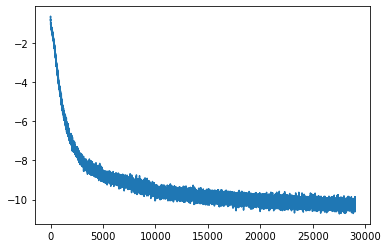

In [21]:
u = PDE_Net(1)
num_eps = 30000
low = -1
high = np.pi+1
sampler = torch.distributions.uniform.Uniform(low, high)
#α = 0.0001
losses = []

# initialize values for ADAM optimizer
m = []
v = []
for param in u.parameters():
    m.append(torch.zeros_like(param))
    v.append(torch.zeros_like(param))
β1 = torch.tensor([0.9])
β2 = torch.tensor([0.999])
ϵ = 1e-8

# mini-batches successfully implemented
mini_batch_size = 256

for ep in range(num_eps):
    lr = funcLearnRate(ep)
    
    u.zero_grad()
    
    # sample a mini_batch of x and t values from a given distribution
    x = sampler.sample((mini_batch_size, 1))
    x.requires_grad_()
    x_init = sampler.sample((mini_batch_size, 1))
    x_init.requires_grad_()
    t = sampler.sample((mini_batch_size, 1))
    t.requires_grad_()
    
    # evaluate forward pass, compute derivatives of network with respect to x and t,
    # and evaluate network at intial time
    u_output = u(x, t)
    u_x = torch.autograd.grad(torch.sum(u_output), x, create_graph=True)[0]
    u_t = torch.autograd.grad(torch.sum(u_output), t, create_graph=True)[0]
    u_inish = u(x_init, torch.zeros_like(t))
    true_inish = torch.sin(x_init)
    
    # compute loss for PDE and initial condition
    L1 = torch.mean(torch.pow(u_t + u_x, 2))
    L2 = torch.mean(torch.pow(u_inish - true_inish, 2))
    G = 5*L1 + L2
    losses.append(torch.log(G).detach())
    
    # compute derivative of loss with respect to network parameters
    G_grad = torch.autograd.grad(G, u.parameters(), retain_graph=True)
    
    # update network parameters with ADAM
    with torch.no_grad():
        i = 0
        for param in u.parameters():
            m[i] = β1*m[i] + (1-β1)*G_grad[i]
            v[i] = β2*v[i] + (1-β2)*torch.pow(G_grad[i], 2)
            m_hat = m[i]/(1-β1**(ep+1))
            v_hat = v[i]/(1-β2**(ep+1))
            param -= lr*m_hat/(torch.sqrt(v_hat)+ϵ)
            i += 1
            
    if ep % 1000 == 0:
        clear_output(wait=True)
        plt.plot(losses)
        plt.show()

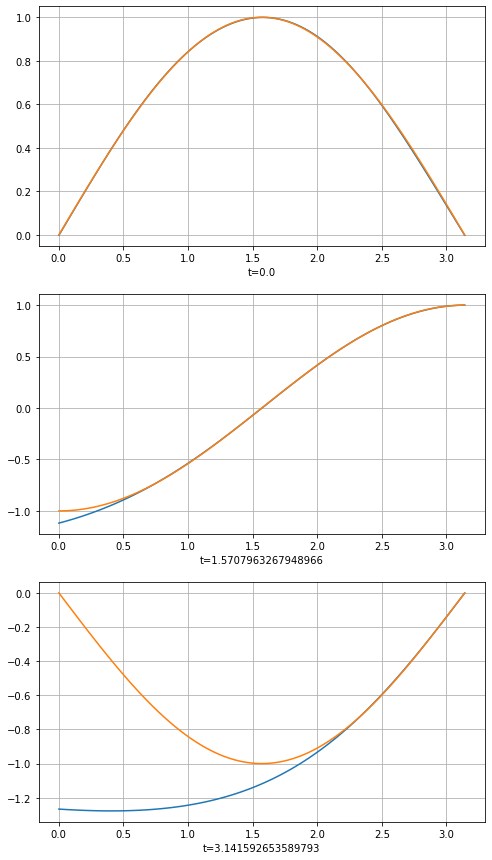

In [22]:
# plot optimized neural net and actual solution
t_vals = [0.0, np.pi/2, np.pi]
x_vals = torch.reshape(torch.linspace(0.0, np.pi, 100), (-1,1))
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))
n = 0
for t in t_vals:
    t_tensor = t*torch.ones(x_vals.size())
    with torch.no_grad():
        u_vals = u(x_vals, t_tensor)
    ax[n].plot(x_vals, u_vals, x_vals, torch.sin(x_vals-t_tensor))
    ax[n].set_xlabel('t={}'.format(t))
    ax[n].grid()
    n += 1

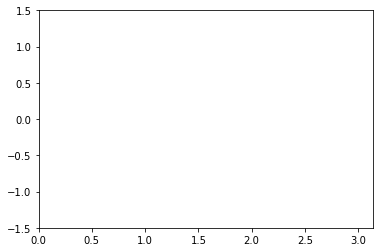

In [77]:
# ANIMATION
# only works with %matplotlib widget but messes up all other plots for some reason

x_vals = torch.reshape(torch.linspace(0.0, np.pi, 100), (-1,1))
fig, ax = plt.subplots()
ax.set_xlim(0.0, np.pi)
ax.set_ylim(-1.5, 1.5)
line1, = ax.plot([])
line2, = ax.plot([])

def animation_frame(t):
    t_tensor = t*torch.ones(x_vals.size())
    with torch.no_grad():
        u_vals = u(x_vals, t_tensor)
    line1.set_data(x_vals, u_vals)
    line2.set_data(x_vals, torch.sin(x_vals-t_tensor))
    return line1, line2

animation = FuncAnimation(fig, func=animation_frame, frames=np.linspace(0.0,np.pi,50), repeat=False)
plt.show()

# Heat Equation
## $u_t - \Delta u = 0, \quad u(\vec{x},0) = \sin(\pi x_1) \sin(\pi x_2)$, zero boundary

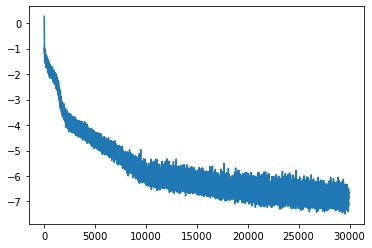

In [59]:
x_dim = 2
u = DGM_Net(d,M,L)
num_eps = 30000
t_sampler = torch.distributions.uniform.Uniform(0.0, 1/10.0)
x_sampler = torch.distributions.uniform.Uniform(0.0, 1.0)
losses = []

# initialize values for ADAM optimizer
m = []
v = []
for param in u.parameters():
    m.append(torch.zeros_like(param))
    v.append(torch.zeros_like(param))
β1 = torch.tensor([0.9])
β2 = torch.tensor([0.999])
ϵ = 1e-8

# mini-batches successfully implemented
mini_batch_size = 128

# used in calculating boundary loss
zeros = torch.zeros(mini_batch_size,1)
ones = torch.ones(mini_batch_size,1)

for ep in range(num_eps):
    lr = funcLearnRate(ep)
    
    u.zero_grad()
    
    # sample a mini_batch of x and t values from a given distribution
    x = x_sampler.sample((mini_batch_size, x_dim))
    x.requires_grad_()
    t = t_sampler.sample((mini_batch_size, 1))
    t.requires_grad_()
    
    # evaluate forward pass, compute derivatives of network with respect to x and t,
    u_output = u(x, t)
    u_grad = torch.autograd.grad(torch.sum(u_output), x, create_graph=True)[0]
    Δu = 0.0
    for i in range(x_dim):
        Δu += (torch.autograd.grad(torch.sum(u_grad[:,i]), x, create_graph=True)[0][:,i]).reshape(-1,1)
    u_t = torch.autograd.grad(torch.sum(u_output), t, create_graph=True)[0]
    L1 = torch.mean(torch.pow(u_t - Δu, 2))
    
    # evaluate initial condition
    pi = torch.tensor([math.pi])
    true_inish = torch.sin(pi*x[:,0].reshape(-1,1))*torch.sin(pi*x[:,1].reshape(-1,1))
    u_inish = u(x,torch.zeros_like(t))
    L2 = torch.mean(torch.pow(u_inish - true_inish, 2))
    
    # evaluate boundary condition
    north = torch.cat((x[:,0].reshape(-1,1),ones),1)
    u_north = u(north,t)
    south = torch.cat((x[:,0].reshape(-1,1),zeros),1)
    u_south = u(south,t)
    east = torch.cat((ones, x[:,1].reshape(-1,1)),1)
    u_east = u(east,t)
    west = torch.cat((zeros, x[:,1].reshape(-1,1)),1)
    u_west = u(west,t)
    L3 = torch.mean(torch.pow(u_north + u_south + u_east + u_west, 2))
    
    G = L1 + L2 + L3
    losses.append(torch.log(G).detach())
    
    # compute derivative of loss with respect to network parameters
    G_grad = torch.autograd.grad(G, u.parameters(), retain_graph=True)
    
    # update network parameters with ADAM
    with torch.no_grad():
        i = 0
        for param in u.parameters():
            m[i] = β1*m[i] + (1-β1)*G_grad[i]
            v[i] = β2*v[i] + (1-β2)*torch.pow(G_grad[i], 2)
            m_hat = m[i]/(1-β1**(ep+1))
            v_hat = v[i]/(1-β2**(ep+1))
            param -= lr*m_hat/(torch.sqrt(v_hat)+ϵ)
            i += 1
            
    if ep % 100 == 0:
        clear_output(wait=True)
        plt.plot(losses)
        plt.show()

tensor([[0.9787]])


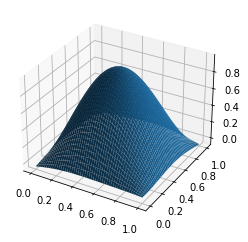

In [76]:
grid_nums = 50
t_val = 0.0
x_grid = torch.linspace(0.0,1.0,grid_nums)
XX, YY = torch.meshgrid(x_grid,x_grid)
X = torch.reshape(XX, (-1,1))
Y = torch.reshape(YY, (-1,1))
XY = torch.cat((X,Y),1)
with torch.no_grad():
    U = u(XY,t_val*torch.ones_like(X))
UU = torch.reshape(U, (grid_nums,grid_nums))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(XX.numpy(),YY.numpy(),UU.numpy())
with torch.no_grad():
    print(u(torch.tensor([[0.5,0.5]]),torch.tensor([[t_val]])))

## More debugging stuff

In [ ]:
xy = torch.tensor([[1.0,2.0],
                   [1.0,3.0],
                   [1.0,4.0]], requires_grad=True)

f = xy[:,0]**3/3 + xy[:,1]**3/3
f_grad = torch.autograd.grad(torch.sum(f),xy, create_graph=True)[0]
print(f_grad)
Δf = 0.0
for i in range(2):
    Δf += (torch.autograd.grad(torch.sum(f_grad[:,i]), xy, create_graph=True)[0][:,i]).reshape(-1,1)
print(Δf)

In [ ]:
xy = torch.tensor([[1.0,2.0],[1.0,3.0]], requires_grad=True)
xy[:,0]

In [ ]:
class Test_Net(nn.Module):
    def __init__(self):
        super(Test_Net,self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128,1))
        
    def forward(self,xt):
        return self.net(xt)

In [ ]:
batch_size = 3
sampler = torch.distributions.uniform.Uniform(-1.0, 1.0)
x_batch = sampler.sample((batch_size,1))
x_batch.requires_grad_()
print(x_batch.size())
t_batch = sampler.sample((batch_size,1))
t_batch.requires_grad_()
print(t_batch)
xt = torch.cat((x_batch,t_batch),1)
print(xt)

f = Test_Net()
f(xt)

In [ ]:
x = torch.tensor(np.cbrt(np.pi), requires_grad=True)
y = torch.pow(x,3)
f_output = torch.sin(y)
fx = torch.autograd.grad(f_output,y,create_graph=True)[0]
fx

In [ ]:
# this doesn't work well
Δ = torch.tensor([1e-6])
w = torch.normal(torch.tensor([0.0]),torch.sqrt(Δ))
σ = torch.sqrt(torch.tensor([2.0]))
x = torch.tensor([1.0], requires_grad=True)
f_output = x**2
f_x = torch.autograd.grad(f_output, x, create_graph=True)[0]
x_step = x + σ*w
f_step =x_step**2
f_x_step = torch.autograd.grad(f_step, x_step, create_graph=True)[0]
f_xx = (f_x_step - f_x)*σ*w/(2*Δ)
f_xx